# Model Evaluation: Logistic Regression
- Evaluation of Hyperparameter Tuning Results.
- For a detailed explanation of model selection, hyperparameter tuning, and evaluation metrics, please refer to the [README.md](./README.md).


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import joblib

import utils.plotting_evaluation as plot_eval
import utils.model_evaluation as model_eval

import pipelines.define_pipelines_log_regression as pipeline_def
import pipelines.custom_pipeline_components as pipeline_comp



In [2]:
# Definitions
features = ["Pregnancies", "Glucose", "BP", "Skin", "Insulin", "BMI", "DPF", "Age"]
scoring_metrics_grid = ["accuracy", "f1", "roc_auc"]  # scoring metrics used in the hyperparameter tuning (currently not using precision and recall)
grid_results_path = "../results/grid_search_results_log_regression"  # path to directory with results of grid search
pipeline_dict = pipeline_def.define_pipelines()  # dict of pipelines used in the hyperparameter search
n_splits = 10  # number of folds for cross-validation in hyperparameter tuning



                        Best Model for Pipeline: KNN PCA
Best hyperparameters saved to ../src/models/best_params/knn_pca_best_params_log_reg.pkl


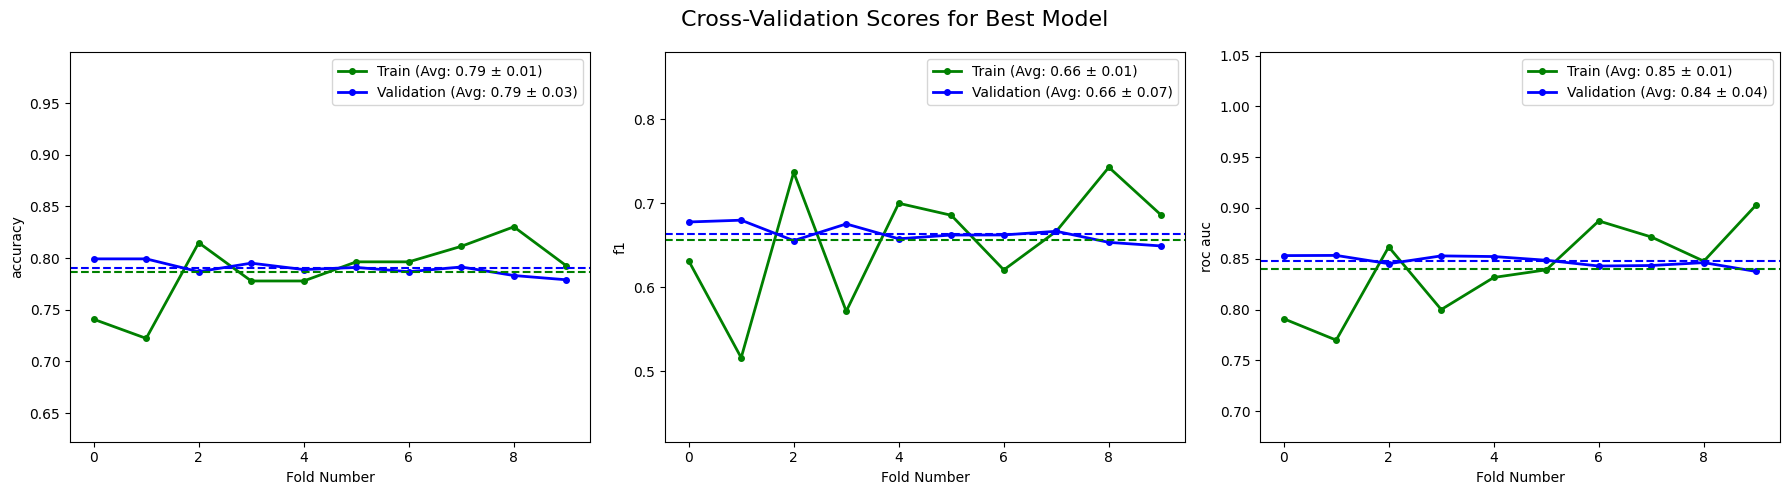


                        Best Model for Pipeline: KNN
Best hyperparameters saved to ../src/models/best_params/knn_best_params_log_reg.pkl


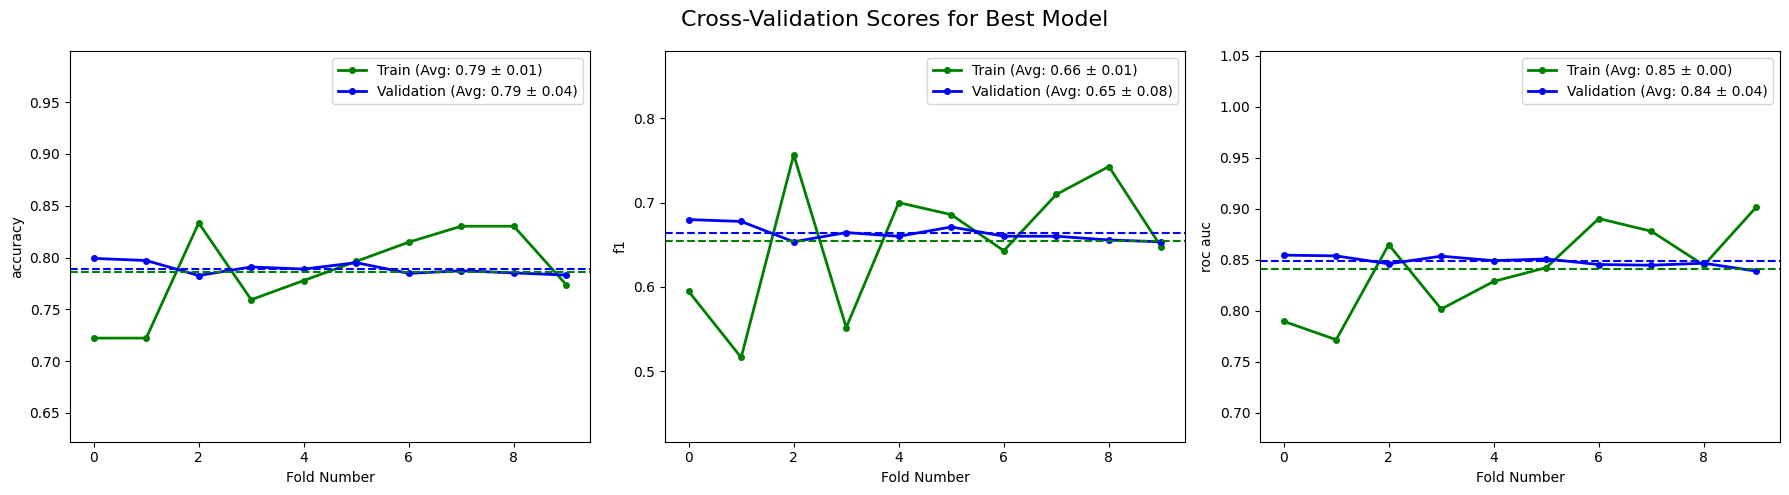


                        Best Model for Pipeline: MEAN
Best hyperparameters saved to ../src/models/best_params/mean_best_params_log_reg.pkl


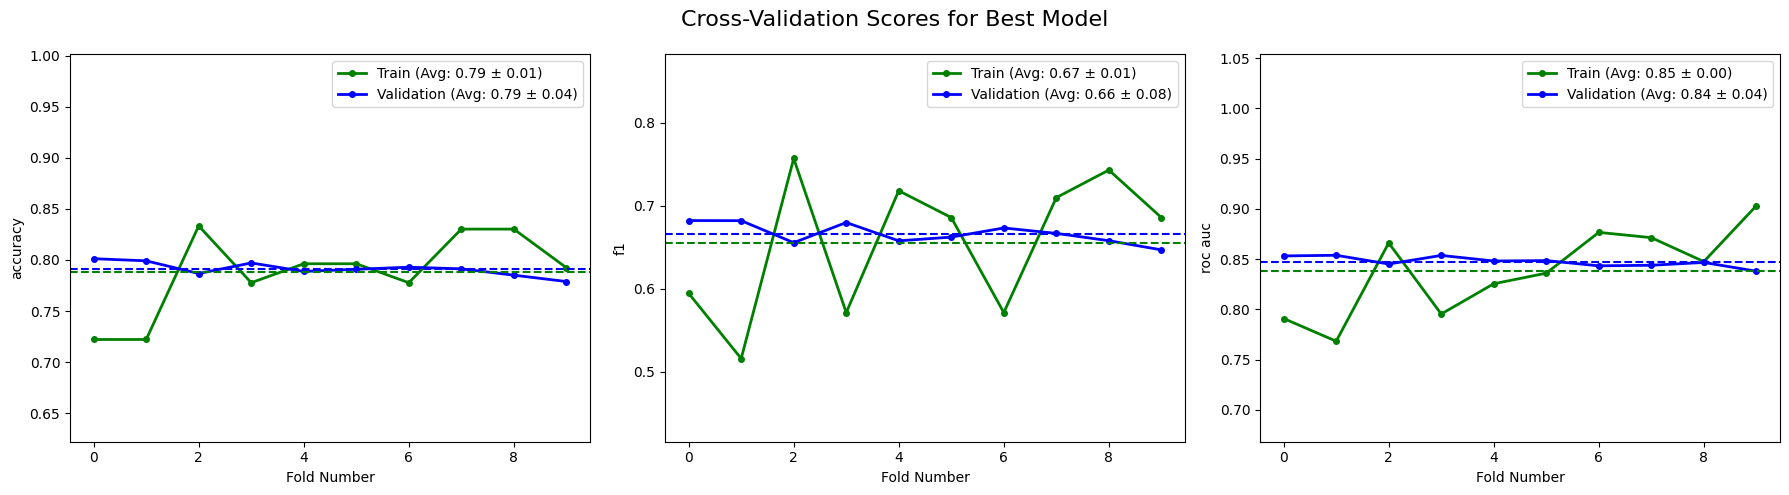


                        Best Model for Pipeline: MEDIAN
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/median_best_params_log_reg.pkl


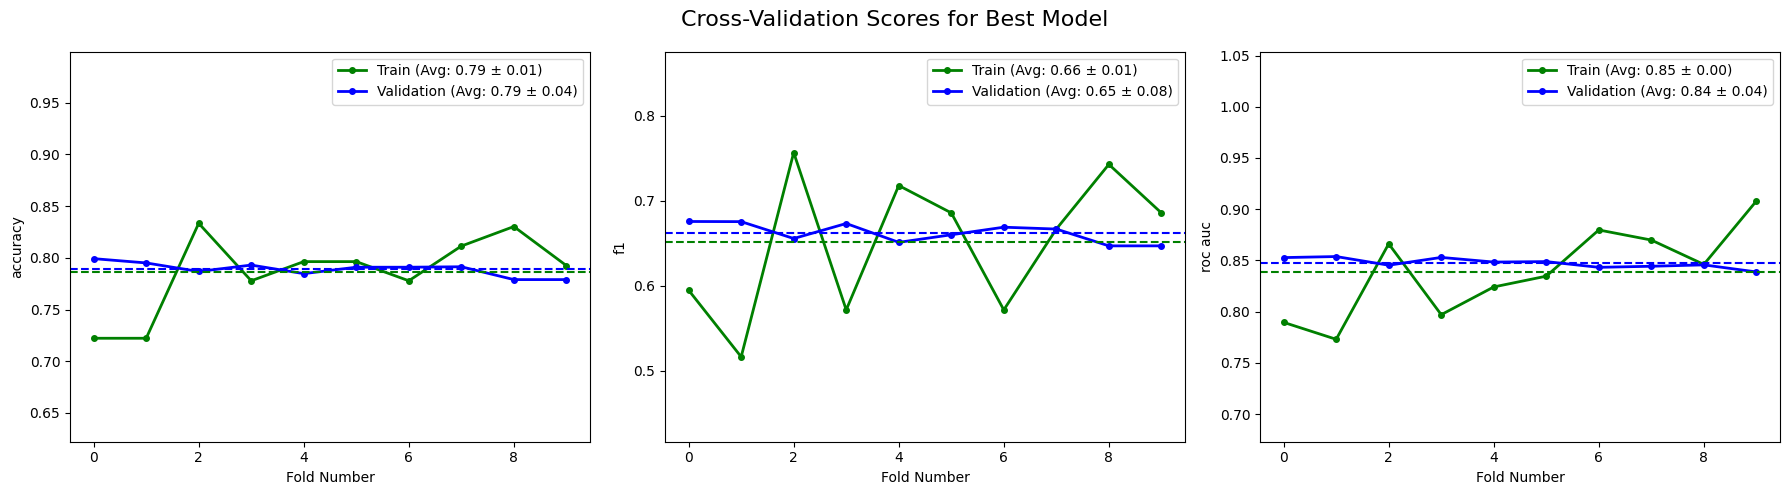


                        Best Model for Pipeline: KNN PCA NO KMEANS
Best hyperparameters saved to ../src/models/best_params/knn_pca_no_kmeans_best_params_log_reg.pkl


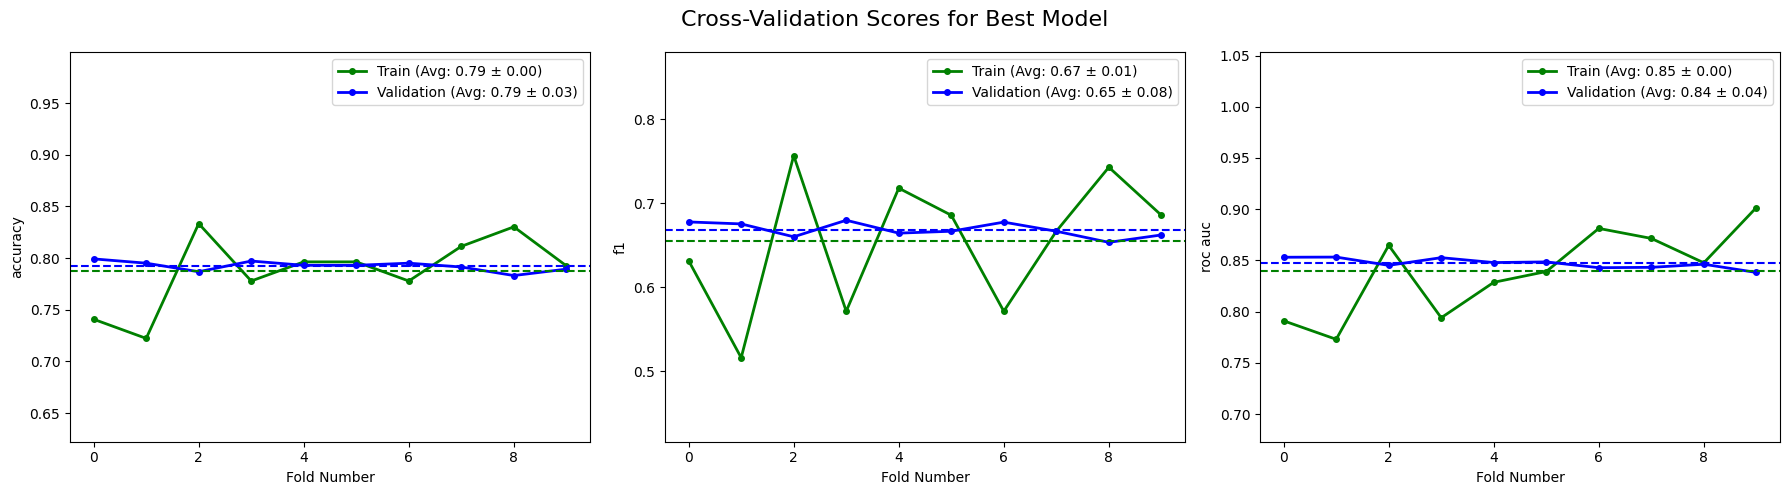


                        Best Model for Pipeline: KNN NO KMEANS
Best hyperparameters saved to ../src/models/best_params/knn_no_kmeans_best_params_log_reg.pkl


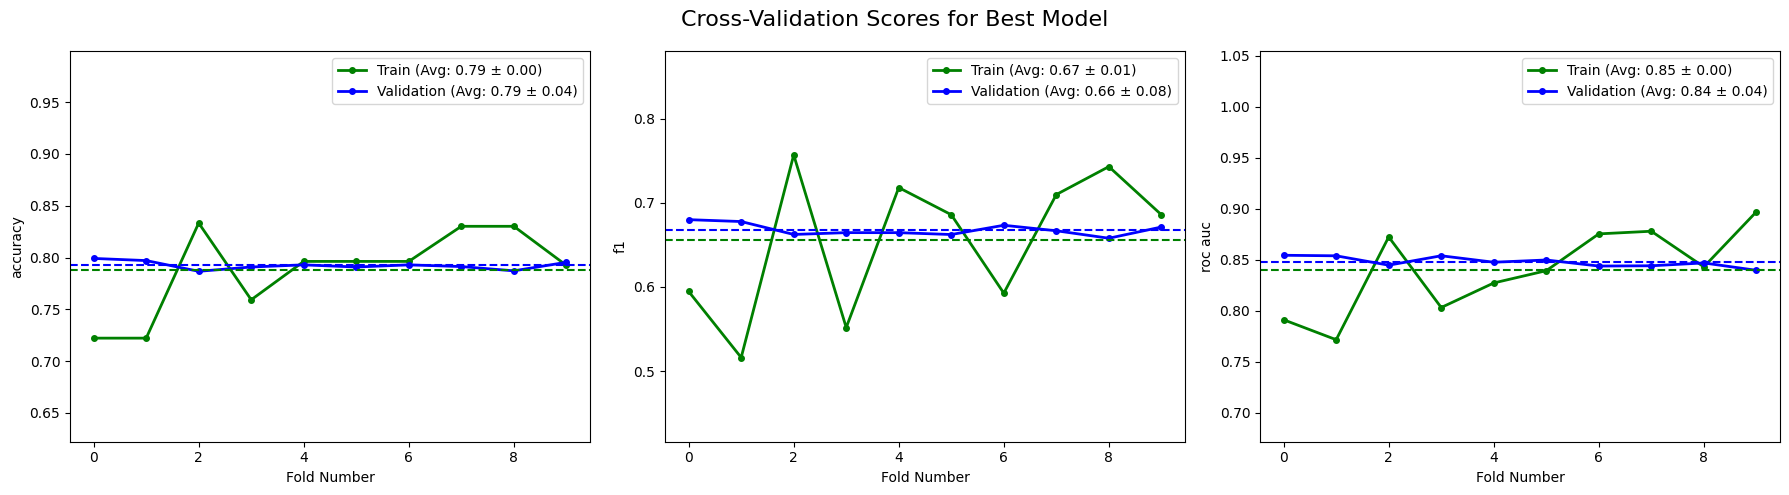


                        Best Model for Pipeline: MEAN NO KMEANS
Best hyperparameters saved to ../src/models/best_params/mean_no_kmeans_best_params_log_reg.pkl


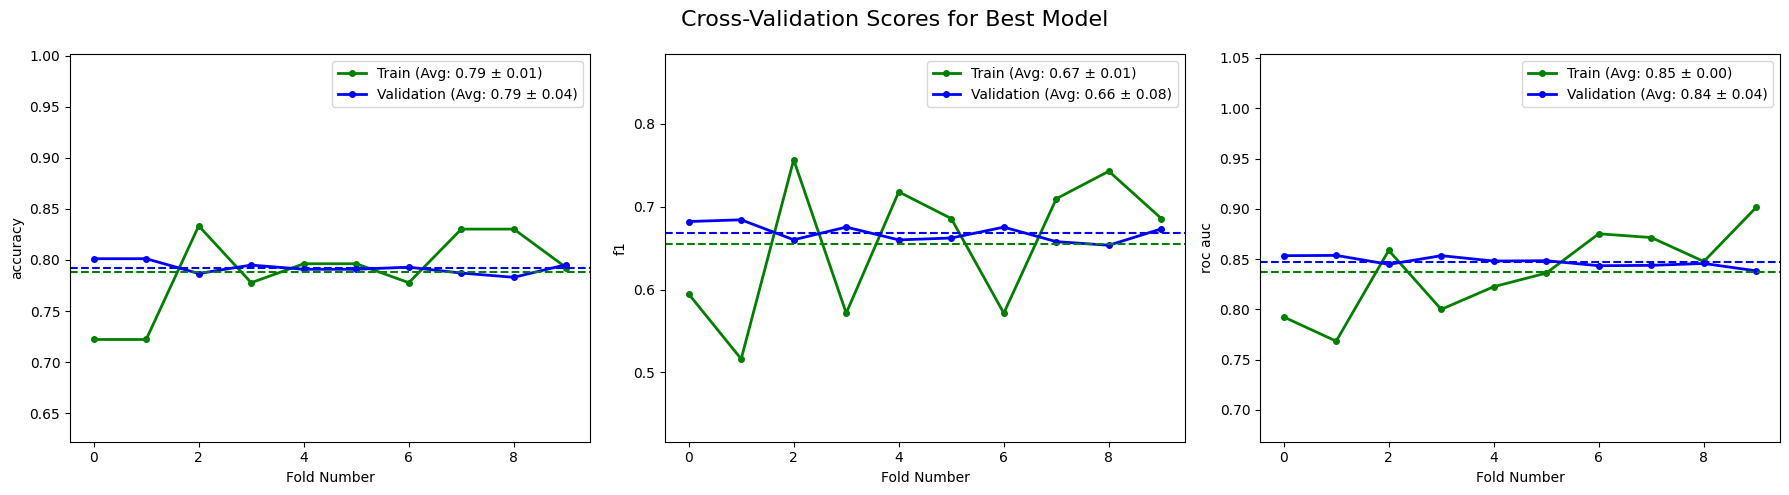


                        Best Model for Pipeline: MEDIAN NO KMEANS
Best hyperparameters saved to ../src/models/best_params/median_no_kmeans_best_params_log_reg.pkl


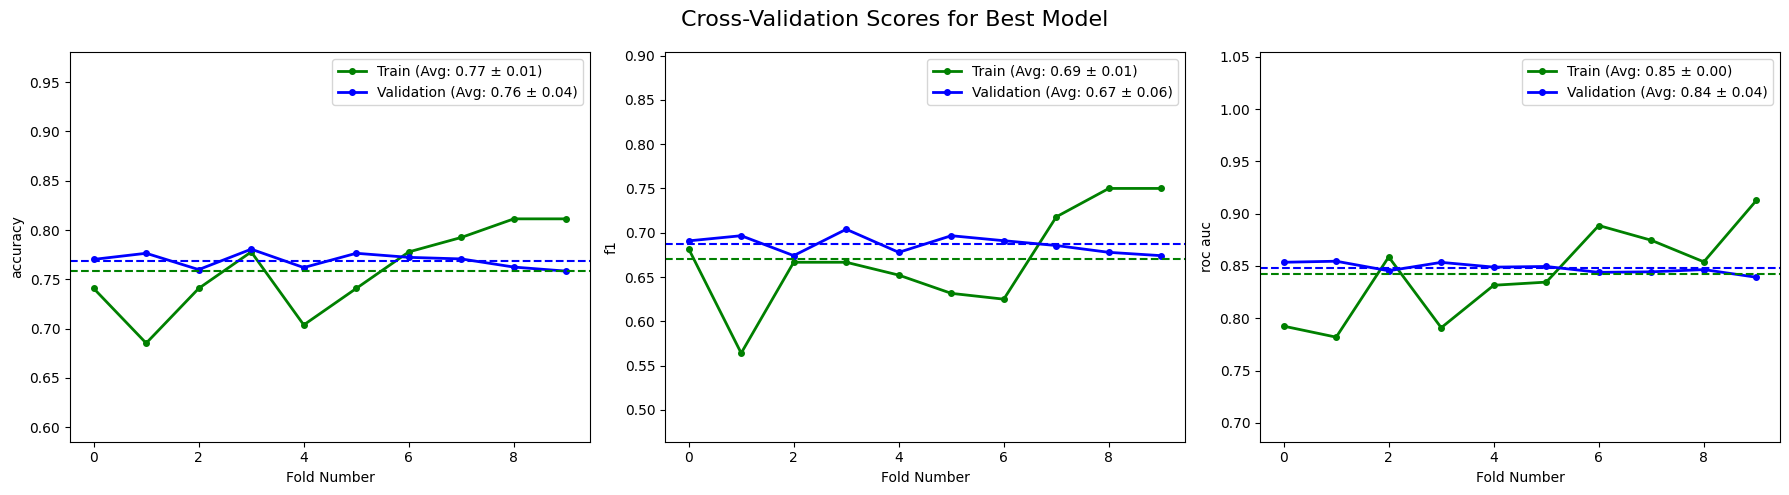

In [3]:
columns = [f"{stat}_{metric}" for metric in scoring_metrics_grid for stat in ['mean_train', 'mean_test', 'std_train', 'std_test']]
best_models_df = pd.DataFrame(columns = columns + ["pipeline_name"])

for pipeline_name, pipeline in pipeline_dict.items():
    
    print("\n" + "=" * 100)
    print(f"                        Best Model for Pipeline: {pipeline_name.replace('_',' ').upper()}")
    print("=" * 100)
    
    try:
        # Determine the best model and the best hyperparameters for the current pipeline
        best_params, best_model_scores = model_eval.determine_best_model(pipeline_name, grid_results_path, scoring_metrics_grid,
                                                                        score_diff_threshold = 0.05, std_test_threshold = 0.05,
                                                                        printing = False) # prining = True gives add info
        
        # If None is returned (no model found), skip this pipeline
        if best_params is None or best_model_scores is None:
            print(f"[Warning] No model found for pipeline {pipeline_name}. Skipping pipeline.")
            continue  # Skip the rest of the loop and move on to the next pipeline
        
        # Save the best hyperparameters
        model_eval.save_best_params(best_params, pipeline_name, classifier_type = "log_reg")
        
        # Plot the Cross-Validation scores for the best model
        plot_eval.plot_cv_scores_for_best_model(best_model_scores, scoring_metrics_grid, n_splits)
        
        # Update the pipeline with the best parameters
        pipeline.set_params(**best_params)
        
        # Add the results to the DataFrame
        new_row = best_model_scores[columns].tolist() + [pipeline_name.replace('_',' ').upper()]
        best_models_df.loc[len(best_models_df)] = new_row
        
    except Exception as e:
        # Handle errors that occur during processing
        print(f"[Error] Error processing pipeline {pipeline_name}: {e}")
        continue  # Skip the pipeline in case of an error

In [4]:
for metric in scoring_metrics_grid:
    best_models_df[f"diff_train_test_{metric}"] = best_models_df[f"mean_train_{metric}"] - best_models_df[f"mean_test_{metric}"]
mean_test_score_cols = [f"mean_test_{metric}" for metric in scoring_metrics_grid ]
std_test_score_cols = [f"std_test_{metric}" for metric in scoring_metrics_grid ]
diff_score_cols = [f"diff_train_test_{metric}" for metric in scoring_metrics_grid ]

best_models_df[["pipeline_name"] + mean_test_score_cols + std_test_score_cols + diff_score_cols ].round(2)

,pipeline_name,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,std_test_accuracy,std_test_f1,std_test_roc_auc,diff_train_test_accuracy,diff_train_test_f1,diff_train_test_roc_auc
0,KNN PCA,0.79,0.66,0.84,0.03,0.07,0.04,0.00,0.01,0.01
1,KNN,0.79,0.65,0.84,0.04,0.08,0.04,0.00,0.01,0.01
2,MEAN,0.79,0.66,0.84,0.04,0.08,0.04,0.00,0.01,0.01
3,MEDIAN,0.79,0.65,0.84,0.04,0.08,0.04,0.00,0.01,0.01
4,KNN PCA NO KMEANS,0.79,0.65,0.84,0.03,0.08,0.04,0.00,0.01,0.01
5,KNN NO KMEANS,0.79,0.66,0.84,0.04,0.08,0.04,0.00,0.01,0.01
6,MEAN NO KMEANS,0.79,0.66,0.84,0.04,0.08,0.04,0.00,0.01,0.01
7,MEDIAN NO KMEANS,0.76,0.67,0.84,0.04,0.06,0.04,0.01,0.02,0.01


### Comparison of Validation Scores
- All the pipelines show similar performance when tuned with their best parameters.
- The best values for each column are marked in **bold**.


| Pipeline             | Mean Test Accuracy | Mean Test F1 | Mean Test ROC AUC | Std Test Accuracy | Std Test F1 | Std Test ROC AUC | Diff Train-Test Accuracy | Diff Train-Test F1 | Diff Train-Test ROC AUC |
|----------------------|--------------------|--------------|-------------------|-------------------|-------------|------------------|--------------------------|---------------------|--------------------------|
| KNN PCA             |  0.7860  |  0.6558  |  0.8403  |**0.0315**|  0.0682  |  0.0409  |  0.0040  |**0.0082**|  0.0072  |
| KNN                 |  0.7860  |  0.6547  |  0.8412  |  0.0402  |  0.0761  |  0.0415  |  0.0034  |  0.0088  |  0.0070  |
| Mean                |**0.7879**|  0.6552  |  0.8382  |  0.0383  |  0.0799  |  0.0409  |  0.0034  |  0.0112  |  0.0093  |
| Median              |  0.7860  |  0.6509  |  0.8388  |  0.0365  |  0.0780  |  0.0412  |**0.0030**|  0.0111  |  0.0086  |
| KNN PCA No KMeans   |  0.7878  |  0.6546  |  0.8392  |  0.0336  |  0.0761  |  0.0404  |  0.0044  |  0.0138  |  0.0079  |
| KNN No KMeans       |**0.7879**|  0.6554  |  0.8396  |  0.0391  |  0.0803  |**0.0395**|  0.0046  |  0.0126  |  0.0080  |
| Mean No KMeans      |**0.7879**|  0.6552  |  0.8374  |  0.0383  |  0.0799  |  0.0396  |  0.0046  |  0.0132  |  0.0099  |
| Median No KMeans    |  0.7582  |**0.6706**|**0.8420**|  0.0410  |**0.0550**|  0.0418  |  0.0107  |  0.0163  |**0.0059**|  



### Model Selection Based on Ranking
- Since all models have a similar performance ranking is applied to chose the best model.
- Each model is ranked based on:
    - **F1 Score** and **ROC AUC** from the **mean test scores**.
    - **Standard deviation** of these metrics from the **validation scores**.
- The difference between training and validation scores is consistently below **0.02**, indicating good generalization. Therefore, these differences are **not considered** in the ranking process.

In [5]:
# Create a copy of the DataFrame for ranking
best_models_df_ranks = best_models_df.copy()

# Define relevant metric columns
sel_test_score_cols = ['mean_test_f1', 'mean_test_roc_auc']
sel_std_test_score_cols = ['std_test_f1', 'std_test_roc_auc']

# Rank mean test scores (higher is better → descending order)
for col in sel_test_score_cols:
    best_models_df_ranks[f"rank_{col}"] = best_models_df_ranks[col].round(3).rank(ascending=False, method="dense")

# Rank standard deviation scores (lower is better → ascending order)
for col in sel_std_test_score_cols:
    best_models_df_ranks[f"rank_{col}"] = best_models_df_ranks[col].round(3).rank(ascending=True, method="dense")

# Calculate the overall rank by summing individual ranks
ranked_vars = [f"rank_{col}" for col in sel_test_score_cols + sel_std_test_score_cols]
best_models_df_ranks["Overall Rank"] = best_models_df_ranks[ranked_vars].sum(axis=1)

# Sort by overall rank (best model at the top)
best_models_df_ranks_sorted = best_models_df_ranks[["pipeline_name", "Overall Rank"] + ranked_vars].sort_values("Overall Rank", ascending=True)

# Display the final ranked DataFrame
best_models_df_ranks_sorted[["pipeline_name", "Overall Rank"] + ranked_vars]


,pipeline_name,Overall Rank,rank_mean_test_f1,rank_mean_test_roc_auc,rank_std_test_f1,rank_std_test_roc_auc
7,MEDIAN NO KMEANS,7.0,1.0,1.0,1.0,4.0
0,KNN PCA,10.0,2.0,3.0,2.0,3.0
1,KNN,12.0,3.0,2.0,3.0,4.0
4,KNN PCA NO KMEANS,12.0,3.0,4.0,3.0,2.0
5,KNN NO KMEANS,12.0,3.0,3.0,5.0,1.0
3,MEDIAN,15.0,4.0,4.0,4.0,3.0
2,MEAN,16.0,3.0,5.0,5.0,3.0
6,MEAN NO KMEANS,16.0,3.0,6.0,5.0,2.0



  
<div style="background-color: orange; padding: 10px;  color: black;">
  <p><strong>Key Observations</strong></p>

- Highest F1 Score → MEDIAN No KMeans(0.6706).
- Highest ROC AUC → MEDIAN No KMeans(0.8420) and KNN PCA(0.8403).
- Best Balance Between F1 and ROC AUC → MEDIAN No KMeans (F1 = 0.6706, ROC AUC = 0.8420).
- Lowest Standard Deviation in F1  → Median No KMeans (0.0550).
- Lowest Standard Deviation in ROC AUC  → KNN No KMeans (0.0395).

  → Choose the pipeline <strong> MEDIAN NO KMeans</strong> as the best model for now since it shows the overall best performance.
</div>


### Fit best pipeline

In [6]:
# Load data
data_train = pd.read_csv("../data/preprocessed_diabetes_train.csv")
# Define features (with original name) and target
features_org = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
                'DiabetesPedigreeFunction', 'Age']

target = "Outcome"

X_train, y_train = data_train[features_org], data_train[target]


In [7]:
with open("../src/models/best_params/median_no_kmeans_best_params_log_reg.pkl", "rb") as f:
    best_params = pickle.load(f)

best_pipeline = pipeline_dict["median_no_kmeans"]
best_pipeline.set_params(**best_params)
best_pipeline.fit(X_train, y_train)
display(best_pipeline)

Pipeline(steps=[('rename', RenameFeatures()),
                ('preprocess',
                 PreprocessFeatures(features_no_measurements=['Glucose', 'BP',
                                                              'Skin', 'Insulin',
                                                              'BMI'])),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [8]:
# Save the best pipeline to a file
joblib.dump(best_pipeline, '../src/models/best_log_reg_pipeline.pkl')

['../src/models/best_log_reg_pipeline.pkl']

### Feature Importance

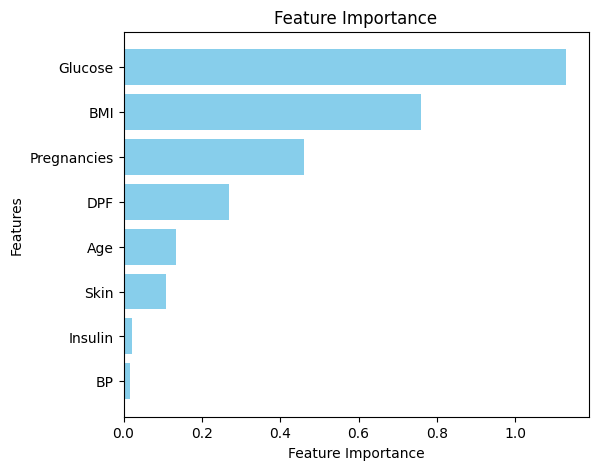

In [9]:
plot_eval.plot_best_model_feature_importance(best_pipeline, features) 

#### Shap values for predicting class 1 (Diabetic)

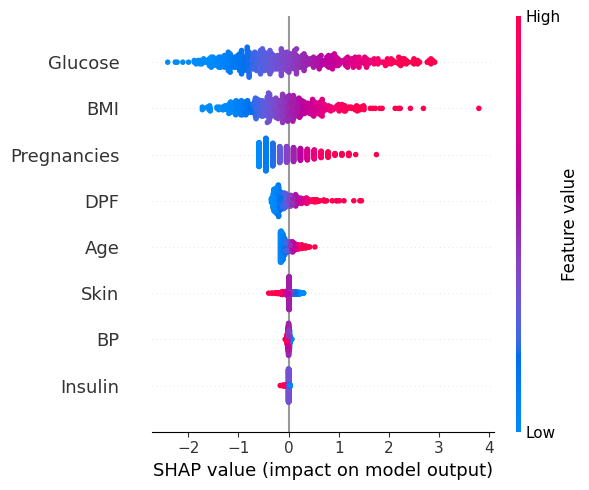

In [10]:
plot_eval.plot_shap_values_for_class_1(best_pipeline, X_train, y_train, features)

### Discussion of Features

**Most Important Features**

- Glucose: High glucose values significantly influence the prediction, increasing the likelihood of being classified as "Diabetic."
- BMI (Body Mass Index): High BMI values tend to push the prediction towards the "Diabetic" class.
- Pregancies: Pregancies is an important feature contributing to the likelihood of being diabetic.

### Learning Curve
- Determined using the same cross-fold validation data as in hyperparameter search to prevent data leakage.
- **Training Score**: Decreases (or plateaus), indicating the model is not overfitting and is learning to generalize.
- **Validation Score**: Increases, showing the model is improving at predicting unseen data.
- **Standard Deviation of Validation Scores**: Decreases, suggesting the model is becoming more stable and less sensitive to specific data subsets.

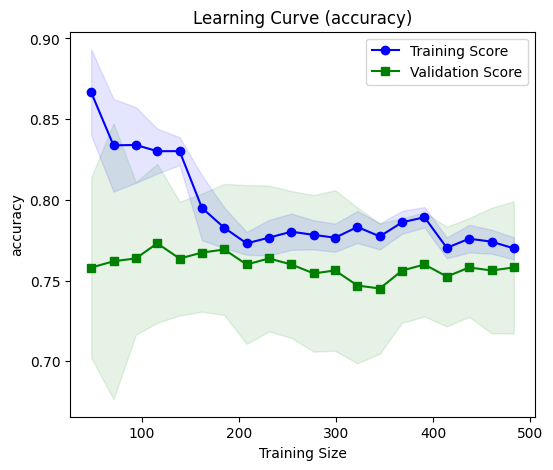

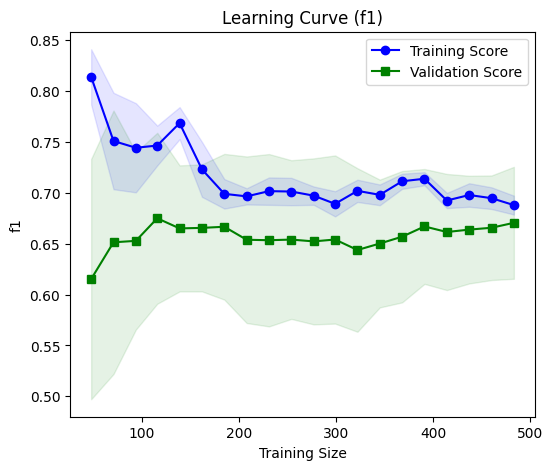

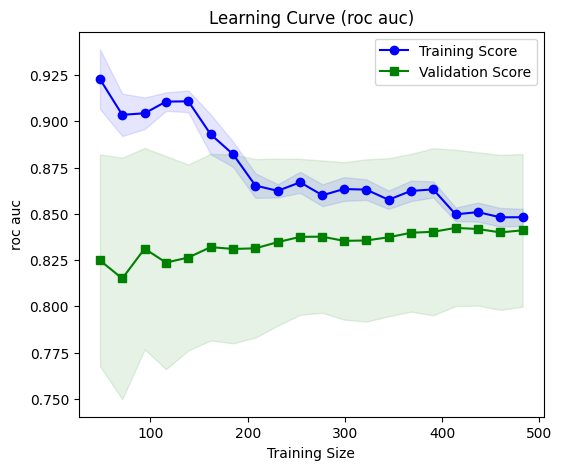

In [11]:
for metric in scoring_metrics_grid:
    plot_eval.plot_learning_curve(best_pipeline, X_train, y_train, scoring_metric= metric)

### Discussion of Learning Curve

Training Data: The total data set consists of 537 patients, and with 10-fold cross-validation, the maximum training size per fold is 483.

##### 1. Training Behavior: 
   - As more data is added, Accuracy, F1 Score, and AUC-ROC of the training scores decrease, suggesting the model is improving its ability to generalize.

##### 2. Validation Performance:
   - Accuracy, F1 Score, and AUC-ROC of the validation set initially improve and then plateau (except for AUC-ROC, which is still slightly increasing), indicating the model reaches a point of diminishing returns, where additional data no longer significantly boosts performance.

##### 3. Model Stability:
   - The decreasing standard deviation of validation scores for small training sizes indicates that the model is becoming more stable, with less variability in performance across different validation splits. 